<a href="https://colab.research.google.com/github/ElisonSherton/fastai-basic-notebooks/blob/master/Lego_Minifigures_Classification_Using_fastai2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with fastai v2

Image Classification has been a very common usecase since time immemorial however it wasn't until Deep Learning that computers were proficient at doing this task. With the advent of Convolutional Neural Networks this task has become so good that in recent years computers have also beat humans in few classification applications. Building a model to do image classification (MNIST digit recognition) marks the start of the deep learning journey for many beginners. Let's therefore do the same only let's make it even more exciting by using a dataset curated on Kaggle called LEGO Minifigures classification.

fastai2 developed by Jeremy Howard and Sylvain Gugger is a library built on top of PyTorch for deep learning practitioners to ease the process of building/training and inferring from DL models. With relatively a very short code, you can build state of the art models for all tasks using this library; that's how much effort hs gone into making it. So let's leverage it to our benefit and start with this task of image classification.

In [ ]:
# Importing required items
!pip install -Uqq fastbook
!pip install fastai --upgrade

In [27]:
from fastai import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

In [3]:
import os
import pandas as pd
import warnings
from IPython.display import display_html
plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")

In [4]:
# Move to the path where you have kept all your data
pth = '/content/drive/My Drive/Colab Notebooks/LEGO_IC'
os.chdir(pth)

In [5]:
# Read in the index and metadata files and display the structure of the same
paths_dframe = pd.read_csv('./index.csv', index_col=0)
metadata = pd.read_csv('./metadata.csv', index_col=0)

print(f"Index file:")
display_html(paths_dframe.head().to_html(), raw = True)

print(f"\nMetadata file:")
display_html(metadata.head().to_html(), raw = True)

Index file:


,path,class_id,train-valid
0,marvel/0001/001.jpg,1,train
1,marvel/0001/002.jpg,1,valid
2,marvel/0001/003.jpg,1,train
3,marvel/0001/004.jpg,1,train
4,marvel/0001/005.jpg,1,train



Metadata file:


,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA


In [6]:
# On looking closely, we can observe that the minigigure name for marvel's spiderman and sony's spiderman are the same.
# We need to change that before we merge the two datasets together

minifigure_names = metadata.minifigure_name
minifigure_names[16] = "MARVEL SPIDER-MAN"
metadata.minifigure_name = minifigure_names

In [7]:
# Keep only the two required columns in the metadata
metadata = metadata[["class_id", "minifigure_name"]]

# Now merge the two datasets on class_id and override the path dataframe by this new dataframe
paths_dframe = pd.merge(paths_dframe, metadata, how = "inner", on = "class_id")

# Change the train-valid column to include a boolean field indicating whether the item is a validation item
paths_dframe["train-valid"] = paths_dframe["train-valid"].apply(lambda x: x == "valid")

# Display a few entries from the paths dataframe
display_html(paths_dframe.head().to_html(), raw = True)

,path,class_id,train-valid,minifigure_name
0,marvel/0001/001.jpg,1,False,SPIDER-MAN
1,marvel/0001/002.jpg,1,True,SPIDER-MAN
2,marvel/0001/003.jpg,1,False,SPIDER-MAN
3,marvel/0001/004.jpg,1,False,SPIDER-MAN
4,marvel/0001/005.jpg,1,False,SPIDER-MAN


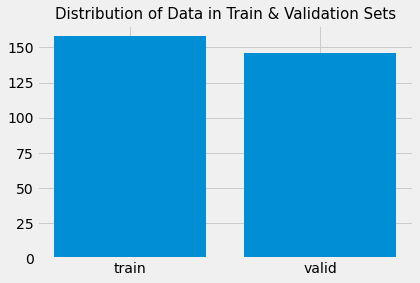

In [11]:
# Check the train-valid counts to get an idea of number of train and validation images in the dataset
valid_n = paths_dframe["train-valid"].sum()
train_n = len(paths_dframe) - valid_n
labels = ["train", "valid"]
fig, ax = plt.subplots(1, 1)
ax.bar(labels, [train_n, valid_n])
ax.set_title("Distribution of Data in Train & Validation Sets", fontsize = 15)
plt.show()

In [12]:
base_path = "./"
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                          # Specify on which column to split for train and validation items
                          splitter=ColSplitter(col="train-valid"),
                          # Specify which columns contain the paths of files with an optional prefix or suffix
                          get_x=ColReader(cols = 0, pref = base_path),
                          # Specify which columns to extract labels for the items from
                          get_y=ColReader(cols = 3),
                          # Specify Item Transforms
                          item_tfms=Resize(224),
                          # Specify Batch Transforms
                          batch_tfms=aug_transforms())

In [13]:
dls = dblock.dataloaders(paths_dframe, bs = 8)

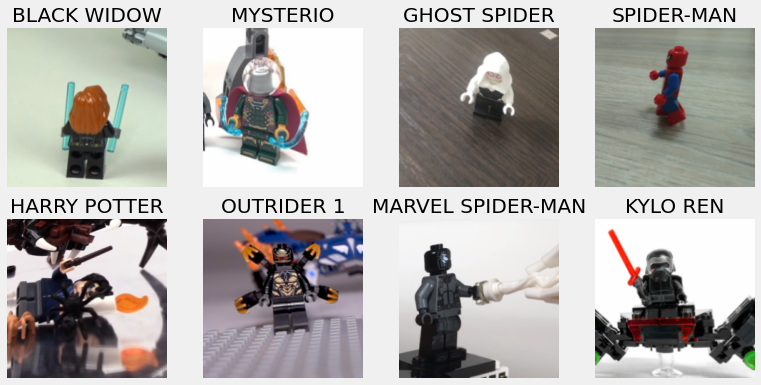

In [ ]:
# Have a look at a sample batch from the dataset
dls.show_batch(max_n = 9)

In [ ]:
# Have a look at all the class names
dls.vocab

(#27) ['AUNT MAY','BLACK WIDOW','CAPTAIN AMERICA','CARA DUNE','FIREFIGHTER','GENERAL GRIEVOUS','GHOST SPIDER','HARRY POTTER','KLATOOINIAN RAIDER 1','KLATOOINIAN RAIDER 2'...]

In [14]:
# Create a learner object with the dataloader defined above
learn = Learner(dls = dls, model = resnet101(pretrained = True), loss_func = CrossEntropyLossFlat(), metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0003311311302240938)

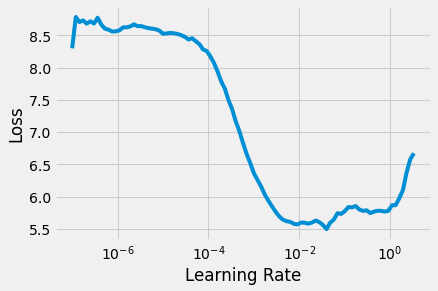

In [ ]:
# Find the appropriate learning rate for the learner defined above
learn.lr_find()

In [15]:
# Use an appropriate learning rate and fit the model 
learn.fit_one_cycle(n_epoch = 25, base_lr = 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,7.446252,5.134257,0.897260,01:25
1,4.122207,0.937894,0.219178,00:05
2,2.357119,1.450466,0.335616,00:05
3,1.778027,10.082988,0.842466,00:05
4,2.098848,5.215235,0.794521,00:05
5,2.214886,9.249713,0.856164,00:05
6,2.173510,4.305371,0.726027,00:05
7,1.906876,4.747465,0.671233,00:05
8,1.666930,2.600983,0.602740,00:05
9,1.519413,2.780012,0.561644,00:05


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=7.585775847473997e-07)

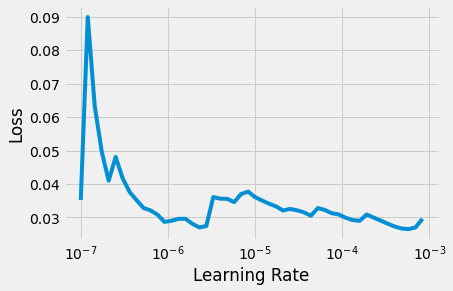

In [16]:
# Unfreeze the previous layers
learn.unfreeze()
learn.lr_find()

In [17]:
# Retrain with all layers made trainable
learn.fit_one_cycle(5, lr_max = 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.034528,0.428399,0.089041,00:05
1,0.038136,0.420984,0.082192,00:05
2,0.046857,0.402210,0.089041,00:05
3,0.041198,0.408749,0.075342,00:05
4,0.042002,0.436058,0.082192,00:05


In [ ]:
# Save the model to make predictions later on
learn.export("Lego_Minifigures_Classifier.pkl")

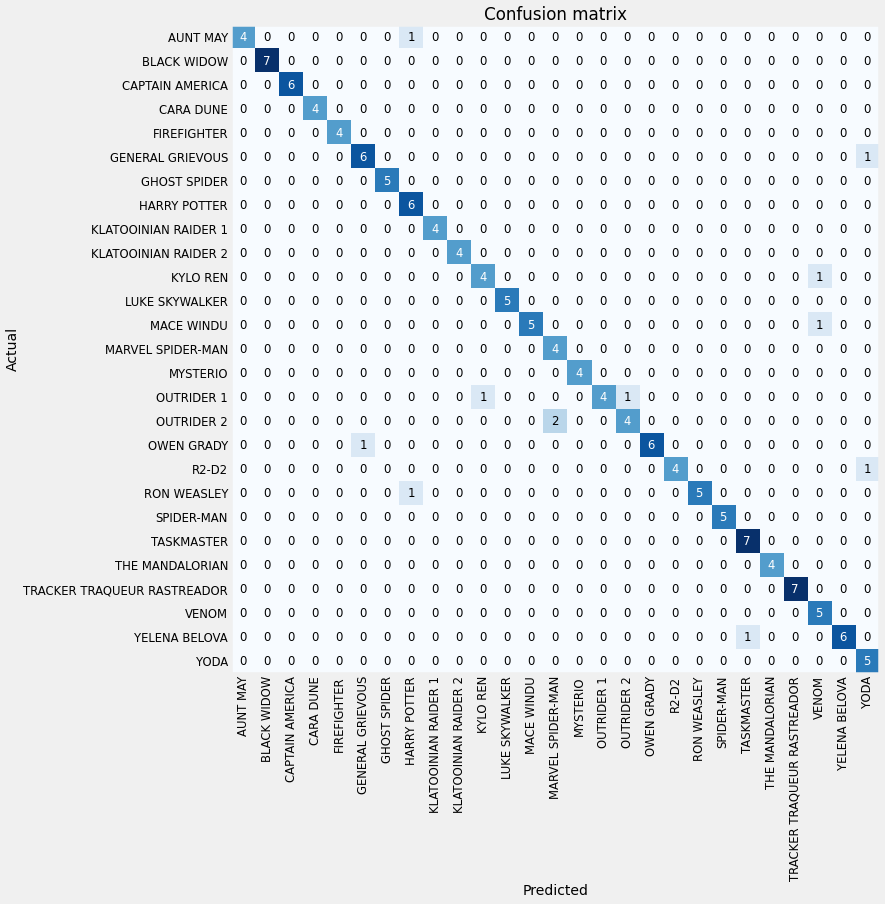

In [18]:
# Model Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(15,15), dpi=60)

In [19]:
# Have a look at the entries which were most confused and hence difficult to predict
interp.most_confused()

[('OUTRIDER 2', 'MARVEL SPIDER-MAN', 2),
 ('AUNT MAY', 'HARRY POTTER', 1),
 ('GENERAL GRIEVOUS', 'YODA', 1),
 ('KYLO REN', 'VENOM', 1),
 ('MACE WINDU', 'VENOM', 1),
 ('OUTRIDER 1', 'KYLO REN', 1),
 ('OUTRIDER 1', 'OUTRIDER 2', 1),
 ('OWEN GRADY', 'GENERAL GRIEVOUS', 1),
 ('R2-D2', 'YODA', 1),
 ('RON WEASLEY', 'HARRY POTTER', 1),
 ('YELENA BELOVA', 'TASKMASTER', 1)]